# Low-Level API

## Prerequisites

If you've already completed the instructions on the **Installation** page, then let's get started.

In [1]:
import aiqc
from aiqc import datum

## 1. Ingest a `Dataset`

### Object Relational Model (ORM)

At the moment, AIQC supports the following types of Datasets:

* Single-file tabular/ flat/ delimited datasets.
* Multi-file image datasets.

End users only need to worry about passing the right inputs to the Dataset class, but there are a few objects doing the legwork beneath the hood:

* `Dataset` ORM class with subclasses of either `Tabular` or `Image`.
  * `File` ORM class one or more files with subclasses of either `Tabular` or `Image`.
    * Dedicated `Tabular` and `Image` ORM classes for attributes specific to those data types (e.g. dtype mappings for flat files and colorscale for images).

> Considering these types in the future: Sequence/ time series: multi-file tabular (e.g. 3D numpy, HDF5). Graph: multi-file nodes and multi-file edges (e.g. DGL).

### Persisting and Compressing Structured Data

By default the actual bytes of the file are persisted to the SQLite `BlobField`. It gets gzip compressed, reducing the size by up to 90%. Maximum BlobField size is 2.147 GB, but once you factor in compression, your bottleneck is more likely to be memory beyond that size. The bytes themselves are Parquet (single-partitioned) because, using the PyArrow engine, it preserves every dtype except certain datetimes (which are honestly better off parsed into floats/ ordinal ints). Parquet is also integrated nicely into both Spark and Dask; frameworks for distributed, in-memory computation.

Persisting the file ensures reproducibility by: (a) keeping the data packaged alongside the experiment, and (b) helping entry-level users move away from relying on mutable dataframes they have had in-memory for extended periods of time or floating around on shared file systems.

> *However, we realize that a different approach will be required at scale, so the `source_path` of the file is recorded whenever possible. In the future we could just read the data from that path (e.g. NFS, RDBMS, HDFS, S3) if the BlobField is none. Or just switch our data fetching/ filtering to Dask because it uses the Pandas API and Parquet.*

### Data Sources

You can make a dataset from either:

* `Dataset.Tabular`

  * In-memory data structures (pandas dataframe, numpy array).
  
  * Flat files (csv, tsv, parquet).
  
    * Accepts urls.


* `Dataset.Image`

  * Any image file format that can be read by the Pillow library.
  
    * Accepts urls.

#### `Dataset.Tabular.from_pandas()`

In [2]:
df = datum.to_pandas('iris.tsv')

dataset = aiqc.Dataset.Tabular.from_pandas(
	dataframe = df
    , name = 'tab separated plants'
    , dtype = None #passed to pd.Dataframe(dtype)/ inferred
    , column_names = None #passed to pd.Dataframe(columns)
)

> Optionally, `dtype`, as seen in the `pandas.DataFrame.astype(dtype)` [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html), can be specified as either a single type for all columns, or as a dictionary that maps a specific type to each column name. This encodes features for analysis. We read NumPy into Pandas before persisting it, so `columns` and `dtype` are read directly by `pd.DataFrame()`.

#### `Dataset.Tabular.from_numpy()`

Must be a 2D NumPy N-Dimensional Array.

> *In the future, we may add support for ingesting 3D arrays as multi-file sequences.*

Regular *ndarrays* don't have column names, and I didn't like the API for *structured arrays* so you have to pass in columns names as a list. If you don't then column names will be numerically assigned in ascending order (zero-based index), but I didn't like the range object, so I stringified numerically assigned columns to string-based numbers.

In [3]:
arr =  df.to_numpy()
cols = list(df.columns)

other_dataset = aiqc.Dataset.Tabular.from_numpy(
	ndarray = arr
    , name = None
    , dtype = None #passed to pd.Dataframe(dtype)/ inferred 
    , column_names = cols #passed to pd.Dataframe(columns)
)

#### `Dataset.Tabular.from_path`

Intended for flat files, delimited text, and structured tabular data. It's read in via Pandas, so it supports URLs to raw data and bytes as well.

The `file_path` itself can be either absolute or relative.

In [4]:
file_path = datum.get_path('iris_10x.tsv')

# We'll keep this larger dataset handy for `Foldset` creation later.
big_dataset = aiqc.Dataset.Tabular.from_path(
    file_path = file_path
    , source_file_format = 'tsv'
    , name = None
    , dtype = None
    , column_names = None
    , skip_header_rows = 'infer' #passed to `pd.read_csv(header)`. Incompatible w Parquet.
)

> If you leave `name` blank, it will default to a human-readble timestamp with the appropriate file extension (e.g. '2020_10_13-01_28_13_PM.tsv').

#### Image Datasets

Image datasets are somewhat multi-modal in that, in order to perform supervised learning on them, they require a loosely coupled `Dataset.Tabular` that contains their labels.

In [5]:
df = datum.to_pandas(name='brain_tumor.csv')
df.head()

status                                                url
0       0  https://github.com/aiqc/aiqc/blob/file_schema/...
1       0  https://github.com/aiqc/aiqc/blob/file_schema/...
2       0  https://github.com/aiqc/aiqc/blob/file_schema/...
3       0  https://github.com/aiqc/aiqc/blob/file_schema/...
4       0  https://github.com/aiqc/aiqc/blob/file_schema/...

The `['status']` column of this dataframe serves as the Label of that sample. We'll construct a `Dataset.Tabular` from this.

In [6]:
tabular_dataset = aiqc.Dataset.Tabular.from_pandas(dataframe=df)

In [7]:
tabular_label = tabular_dataset.make_label(columns=['status'])

#### `Dataset.Image.from_urls()`

During ingestion, all image files must have the same `Image.mode` and `Image.size` according to the Pillow library.

> https://pillow.readthedocs.io/en/stable/handbook/concepts.html

`from_urls(urls:list)` needs a list of urls. In order to perform supervised learning, the order of this list must line up with the samples in your Tabular dataset.
> We happen to have this list prepared in the `['url']` column of the dataframe above.  acts as a manifest in that it contains the URL of the image file for that sample, solely for the purposes of initial ingestion. We'll construct a `Dataset.Image` from this.

In [8]:
image_urls = datum.get_remote_urls(manifest_name='brain_tumor.csv')

In [9]:
image_dataset = aiqc.Dataset.Image.from_urls(urls=image_urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 80/80 [00:24<00:00,  3.29it/s]


In [10]:
image_featureset = image_dataset.make_featureset()

Skipping forward a bit, we bring the heterogenous `Featureset` and `Label` together in the `Splitset`, and they can be used as normal. You can even construct a `Foldset` from this splitset.

In [11]:
image_splitset = image_featureset.make_splitset(
    label_id = tabular_label.id
    , size_test = 0.24
    , size_validation = 0.12
)

#### `Dataset.Image.from_folder()`

When reading images from a locally accessible folder, the fantastic `natsort.natsorted` library is used as the source of truth for the order of the files.
> Python reads files by insertion order rather than alpha-numerically, which isn't intuitive for humans. So make sure your tabular manifest has the same order as `natsorted`. https://natsort.readthedocs.io/en/master/api.html#natsort.natsorted

In [12]:
image_dataset = aiqc.Dataset.Image.from_folder("/Users/layne/desktop/brain_tumor_preprocessed")

🖼️ Ingesting Images 🖼️: 100%|███████████████████████| 80/80 [00:00<00:00, 232.15it/s]


Here you can see the first 3 files that comprise that dataset.

In [13]:
image_dataset.files[:3]

[<File: 85>, <File: 86>, <File: 87>]

In [14]:
image_featureset = image_dataset.make_featureset()

In [15]:
image_splitset = image_featureset.make_splitset(
    label_id = tabular_label.id
    , size_test = 0.24
    , size_validation = 0.12
)

### Reading Datasets

All of the sample-related objects in the API have `to_numpy()` and `to_pandas()` methods that accept the following arguments:

* `samples=[]` list of indices to fetch.
* `columns=[]` list of columns to fetch.
* In some cases you can specify a `split`/ `fold` name.

For structured data, since the `Dataset` itself is fairly removed from the `File.Tabular` it creates, you can get that tabular file with `Dataset.Tabular.get_main_tabular(dataset_id)` to inspect attributes like `dtypes` and `columns`.

Later, we'll see how these arguments allow downstream objects like `Splitset` and `Foldset` to slice up the data.

### `Dataset.Tabular.to_pandas()`

In [16]:
df = dataset.to_pandas()
df.head()

sepal_length  sepal_width  petal_length  petal_width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

In [17]:
df = aiqc.Dataset.to_pandas(
    id = dataset.id 
    , samples = [0,13,29,79]
    , columns = ['sepal_length', 'sepal_width']
)
df.tail()

sepal_length  sepal_width
0            5.1          3.5
13           4.3          3.0
29           4.7          3.2
79           5.7          2.6

### `Dataset.Tabular.to_numpy()`

In [18]:
arr = dataset.to_numpy(
    samples = [0,13,29,79] 
    , columns = ['petal_length', 'petal_width']
)
arr[:4]

array([[1.4, 0.2],
       [1.1, 0.1],
       [1.6, 0.2],
       [3.5, 1. ]])

In [19]:
arr = aiqc.Dataset.to_numpy(id=dataset.id)
arr[:4]

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ]])

### `Dataset.Image.to_pillow()`

Returns a list of `PIL.Image`'s. You can actually see the image when you call them. 

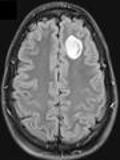

In [20]:
images_pillow = aiqc.Dataset.Image.to_pillow(id=image_dataset.id, samples=[60,61,62])
images_pillow[1]

### `Dataset.Image.to_numpy()`

This simply performs `np.array(Pillow.Image)`. Returns an N-dimensional array where the dimensions vary based on the `mode` aka colorscale of the image. For example, it returns '3D of 2Ds for black and white' or '4D of 3Ds for colored' - which would change the class of convultional layer you would use (`Conv1D`:`Conv3D`).



In [21]:
images_pillow = aiqc.Dataset.Image.to_numpy(id=image_dataset.id, samples=[60,61,62])
images_pillow[1]

array([[11, 11, 11, ..., 18, 18, 18],
       [ 4,  4,  4, ..., 18, 18, 18],
       [ 0,  0,  0, ..., 18, 18, 18],
       ...,
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18]], dtype=uint8)

> At the moment, we haven't found it necessary to provide a `to_pandas` method for images as they have no need for column names, the dtypes are homogenous, images are used as a whole so there is no filtering, Pandas isn't great with 3D data, and Pillow is integrated with NumPy.

## 2. Select the `Label` column(s).

### ORM

From a Dataset, pick the column(s) that you want to predict/ train against. Creating a `Label` won't duplicate your data! It simply marks the Dataset `columns` to be used for supervised learning. 

Later, we'll see that a `Label` triggers:

* The `supervision` attribute of a `Splitset` to be either `'unsupervised'`/`'supervised'`.

* Approval/ rejection of the `Algorithm.analysis_type`. For example, you wouldn't perform regression on a string label.

Part of the magic of this library is that it prevents you from making silly mistakes like these so that you aren't faced with some obscure NumPy/ Tensor, dtype/ dimensionality error on the nth layer of your neural network.

For categorical labels, but not for continuous/float labels, the `Label.unique_classes` are recorded.

### Deriving Labels

Keep the name of the label column handy as you may want to re-use it later when excluding features.

In [22]:
label_column = 'species'

Implicit IDs

In [23]:
label = dataset.make_label(columns=[label_column])

> `columns=[label_column]` is a list in case users have already OneHotEncoded (OHEd) their label. If multiple columns are provided, then they must already be in OHE format. I'm not keen on supporting multi-label/ simultaneous analysis, but that could changed based on feasibility and user demand.

Explicit IDs

In [24]:
other_label = aiqc.Label.from_dataset(
	dataset_id=other_dataset.id
	, columns=[label_column]
)

### Reading Labels

The `Label` comes in handy when we need to fetch what is traditionally referred to as '*Y*' in tutorials. It also accepts a `samples` argument, so that `Splitset` can subset it.

In [25]:
label.to_pandas().tail()

species
145        2
146        2
147        2
148        2
149        2

In [26]:
label.to_numpy(samples=[0,33,66,99,132])[:5]

array([[0],
       [0],
       [1],
       [1],
       [2]])

## 3. Select the `Featureset` column(s).

### ORM

Creating a Featureset won't duplicate your data! It simply records the Dataset `columns` to be used as features during training. 

There are three ways to define which columns you want to use as features:

- `exclude_columns=[]` e.g. use all columns except the label column.
- `include_columns=[]` e.g. only use these columns that I think are informative.
- Leave both of the above blank and all columns will be used (e.g. images or unsupervised leanring).

For structured data, since the Featureset is far removed from the `File.Tabular` that it is derived from, there is a `Featureset.get_dtypes()` method. This will come in handy when we are selecting dtypes/columns to include/ exclude in our `Featurecoder`(s).

### Deriving Labels

Via `include_columns=[]`

In [27]:
include_columns = [
    'sepal_length',
    'petal_length',
    'petal_width'
]

In [28]:
featureset = dataset.make_featureset(include_columns=include_columns)

Via `exclude_columns=[]`

In [29]:
featureset = dataset.make_featureset(exclude_columns=[label_column])

In [30]:
featureset.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Either way, any excluded columns will be recorded since they are used for dropping.

In [31]:
featureset.columns_excluded

['species']

Again, for images, just perform `Dataset.Image.make_featureset()` since you'll likely want to include all pixels and your label column is in a separate, coupled Dataset.

### Reading Featuresets

In [32]:
featureset.to_numpy()[:4]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2]])

In [33]:
featureset.to_pandas(samples=[0,16,32,64]).tail()

sepal_length  sepal_width  petal_length  petal_width
0            5.1          3.5           1.4          0.2
16           5.4          3.9           1.3          0.4
32           5.2          4.1           1.5          0.1
64           5.6          2.9           3.6          1.3

## 4. Slice samples with a `Splitset`.

A `Splitset` divides a the samples of the Dataset into the following *splits* in the table below. It is the central object of the data preparation side of the ORM in that it touches `Label`, `Featureset`, `Foldset`, and `Encoderset`. It is the only mandatory data preparation object required by the training `Queue`.

Both contiuous and categorical `Labels` are automatically stratified.

| Split                 | Description                                                                                                                                                                                             |
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| train                 | The samples that the model will be trained upon. <br/>Later, we’ll see how we can make *cross-folds from our training split*. <br/>Unsupervised learning will only have a training split.                 |
| validation (optional) | The samples used for training evaluation. <br/>Ensures that the test set is not revealed to the model during training.                                                                                  |
| test (optional)       | The samples the model has never seen during training. <br/>Used to assess how well the model will perform on unobserved, natural data when it is applied in the real world aka how generalizable it is. |

Again, creating a Splitset won't duplicate your data. It simply denotes the sample indices (aka rows) to be used in the splits that you specify!

### Split Strategies

#### a) Default supervised 70-30 split.

If you only provide a Label, then 70:30 train:test splits will be generated.

In [34]:
splitset = featureset.make_splitset(label_id=label.id)

#### b) Specifying test size.

In [35]:
splitset = featureset.make_splitset(
	label_id = label.id
	, size_test = 0.30
)

#### c) Specifying validation size.

In [36]:
splitset = featureset.make_splitset(
	label_id = label.id
	, size_test = 0.20
	, size_validation = 0.12
)

#### d) Taking the whole dataset as a training split.

In [37]:
splitset_unsupervised = featureset.make_splitset()

> Label-based stratification is used to ensure equally distributed label classes for both categorical and continuous data.
>
> If you want more control over stratification of continuous splits, specify the number of `continuous_bin_count` for grouping.

#### e) Stratification of continuous labels.

All splits are stratified by default in that they contain similar distributions of unique label classes so that each split is a statistically accurate representation of the population as a whole.

In order to support this process for continuous labels, binning/ discretization is utilized. For example, if 4 bins are used, values from *0.0 to 1.0* would be binned as *[0.0-0.25, 0.25-0.50, 0.50-0.75, 0.75-1.0]*. This is controlled by the `make_splitset(bin_count:int)` argument. 

> Reference the handy `Pandas.qcut()`  and the source code `pd.qcut(x=array_to_bin, q=bin_count, labels=False, duplicates='drop')` for more detail.

### Reading Splitsets

In [38]:
splitset.samples.keys()

dict_keys(['validation', 'train', 'test'])

`.keys()` of 1st layer are referred to as "split_name" in the source code: e.g. 'train' as well as, optionally, 'validation' and 'test'.
  
`Splitset.samples` on disk:
```
 {
     'train': [<sample_indices>],
     'validation': [<sample_indices>],
     'test': [<sample_indices>]
 }
```

You can also verify the actual size of your splits.

In [39]:
splitset.sizes

{'validation': {'percent': 0.12, 'count': 18},
 'test': {'percent': 0.2, 'count': 30},
 'train': {'percent': 0.68, 'count': 102}}

The main attribute of the splitset is the `samples` dictionary. Again, on-disk this only contains sample indices. The dictionary is structured like so:

### `Splitset.to_numpy()`

When fetched to memory, the `.keys()` of the 2nd layer are: 'features' and, optionally, 'labels'.

Note that if you do not specified neither a `size_validation` nor `size_test`, then your dictionary will contain neither a `['validation']` nor `['test']` split.

In [40]:
splitset.to_numpy()['train']['features'][:4]

array([[5. , 3.5, 1.3, 0.3],
       [5.1, 3.3, 1.7, 0.5],
       [5.8, 2.7, 5.1, 1.9],
       [4.5, 2.3, 1.3, 0.3]])

### `Splitset.to_pandas()`

Getting more fine-tuned, both the numpy and pandas methods support a few optional filters for the sake of memory-efficiency when fetching larger splits.

For example, imagine you are fetching data to specifically encode the only float column in the featureset of the test split. You don't need the labels and you don't need the other columns.

In [41]:
splitset.to_pandas(
	splits = ['test']
	, include_label = False
	, include_featureset = True
	, feature_columns = ['sepal_width']
)['test']['features'].head()

sepal_width
35           3.2
113          2.5
78           2.9
128          2.8
133          2.8

## 5. Optionally, create a `Foldset` for cross-validation.

### ORM

*Reference the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html) to learn more about folding.*

![Cross Folds](../images/cross_fold.png)

We refer to the left out fold (blue) as the `fold_validation` and the remaining training data as the `folds_train_combined` (green).

> *In the future, we may introduce more folding `strategies` aside from leave-one-out.*

#### `Fold` objects

For the sake of determining which samples get trained upon, the only thing that matters is the slice of data that gets left out.

> Tip - DO NOT use a `Foldset` unless your *(total sample count / fold_count)* still gives you an accurate representation of your sample population. If you are ignoring that advice and stretching to perform cross-validation, then at least ensure that *(total sample count / fold_count)* is evenly divisible. Both of these tips help avoid poorly stratified/ undersized folds that perform either too well (only most common label class present) or poorly (handful of samples and a few inaccurate prediction on a normally good model).
>
> Tip - The sample indices of the validation fold are not discarded. In fact, `fold_validation` can actually be used alongside a split `validation` for double validation 🤘. However, it's more sensible to skip the validation split when cross-validating because you'll want each `fold_validation` to be as large (representative of the population) as possible. Folds naturally have fewer samples, so a handful of incorrect predictions have the potential to offset your aggregate metrics.
> 
> Candidly, if you've ever performed cross-validation manually, let alone systematically, you'll know that, barring stratification of continuous labels, it's easy enough to construct the folds, but then it's a pain to generate performance metrics (e.g. `zero_division`, absent OHE classes) due to the absence of outlying classes and bins. Time has been invested to handle these scenarios elegantly so that folds can be treated as first-class-citizens alongside splits. That being said, if you try to do something undersized like "150 samples in their dataset and a `fold_count` > 3 with `unique_classes` > 4," then you may run into edge cases.

Similar to `Splitset.samples`, there is a `Fold.samples` dictionary of sample indices with the following `.keys()`:
* `samples['folds_train_combined']` - all the included folds.
* `samples['fold_validation']` - the fold that got left out.

![cross fold objects](../images/cross_fold_objects.png)

### Deriving Foldsets

In [42]:
big_label = big_dataset.make_label(columns=[label_column])
big_fset = big_dataset.make_featureset(exclude_columns=[label_column])
big_splits = big_fset.make_splitset(
	label_id = big_label.id
	, size_test = 0.30
    , bin_count=3
)

Now we are ready to generate 5 `Fold` objects that belong to the `Foldset`.

In [43]:
foldset = big_splits.make_foldset(fold_count=5, bin_count=3)

In [44]:
list(foldset.folds)

[<Fold: 1>, <Fold: 2>, <Fold: 3>, <Fold: 4>, <Fold: 5>]

### Reading Foldsets

##### Sample indices of each Fold:

In [45]:
foldset.folds[0].samples['folds_train_combined'][:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

In [46]:
foldset.folds[0].samples['fold_validation'][:10]

[0, 10, 16, 19, 23, 25, 27, 28, 32, 38]

### `Foldset.to_numpy()`

In order to reduce memory footprint the `to_numpy()` and `to_pandas()` methods introduce the `fold_index` argument.

If no fold_index is specified, then it will fetch all folds and give each fold a numeric key according to its index.

So you need to specify the `fold_index` as the first key when accessing the dictionary.

In [47]:
foldset.to_numpy(fold_index=0)[0]['fold_validation']['features'][:4]

array([[5.1, 3.5, 1.4, 0.2],
       [5.4, 3.7, 1.5, 0.2],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.8, 1.5, 0.3]])

### `Foldset.to_pandas()`

Similar to `splitset.to_numpy(splits:list)`, the `foldset.to_numpy(fold_names:list)` argument allows you to pluck the `['folds_train_combined]` and `['fold_validation]` slices. Just make sure you remember to specific all 3 levels of keys when accessing the result.

In [48]:
foldset.to_pandas(
    fold_index = 0
	, fold_names = ['folds_train_combined']
	, include_label = True
	, include_featureset = False
)[0]['folds_train_combined']['labels'].tail()

species
1042        2
1043        2
1044        2
1045        2
1046        2

## 6. Optionally, stage an `Encoderset` for encoding.

### Background

Certain algorithms either (a) require features and/ or labels formatted a certain way, or (b) perform MUCH better when their values are normalized. For example:

* Converting ordinal or categorical string data `[dog, cat, fish]` into one-hot encoded format `[[1,0,0][0,1,0][0,0,1]]`.
* Scaling continuous features from (-1 to 1) or (0.0 to 1.0). Or transforming them to resemble a more Gaussian distribution.

There are two phases of encoding:
1. `fit` - where the encoder learns about the values of the samples made available to it. Ideally, you only want to `fit` aka learn from your training split so that you are not *"leaking"* information from your validation and test spits into your encoder!
2. `transform` - where the encoder transforms all of the samples in the population.

AIQC has solved the following challenges related to encoding:

* How does one dynamically `fit` on only the training samples in advanced scenarios like cross-validation where a different fold is used for validation each time?

* For certain encoders, especially categorical ones, there is arguably no leakage. If an encoder is arbitrarilly assigning values/ tags to a sample through a process that is not aggregate-informed, then the information that is reveal to the `fit` is largely irrelevant. As an analogy, if we are examining swan color and all of a sudden there is a black swan... it's clearly not white, so slap a non-white label on it and move on. In fact, the prediction process and performance metric calucatlion may fail if it doesn't know how to handle the previously unseen category.

* Certain encoders only accept certain dtypes. Certain encoders only accept certain dimensionality (e.g. 1D, 2D, 3D) or shape patterns (odd-by-odd square). Unfortunately, there is not much uniformity here.

* Certain encoders output extraneous objects that don't work with deep learning libraries.

> *For now, only `sklearn.preprocessing` methods are supported. That may change as we add support for more low-level tensor-based frameworks like PyTorch.*

Keeping this in mind, we create an `Encoderset` for our `Splitset`. We can attach a `Labelcoder` and/ or `Featurecoder`(s).

In [49]:
encoderset = splitset.make_encoderset()

And then import any scikit-learn encoders that you need. AIQC only supports the uppercase methods (e.g. `RobustScaler`, but not `robust_scale`) because the lowercase methods do not separate the `fit` and `transform` steps. FYI, most of the uppercase methods have a combined `fit_transform` method if you need them. 

> https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [50]:
from sklearn.preprocessing import *

## 7. Optionally, set a single `Labelcoder`.

### Background

The simplistic `Labelcoder` is a good warmup for the moe advanced `Featurecoder`.

Of course, you cannot encode Labels if your `Splitset` does not have labels in the first place.

The process is straightforward. You provide an instantiated encoder [e.g. `StandardScaler()` not `StandardScaler`], and then AIQC will:

* Verify that the encoder works with your `Label`'s dtype, sample values, and figure out what dimensionality it needs in order to succeed.

* Validate the attributes of your encoder to smooth out any common errors they would cause.

* Determine whether the encoder should be `fit` either (a) exclusively on the train split, or (b) if it is not prone to leakage, inclusively on the entire dataset thereby reducing the chance of errors arising.

In [51]:
labelcoder = encoderset.make_labelcoder(
    sklearn_preprocess = OneHotEncoder(sparse=False)
)

## 8. Optionally, determine a sequence of `Featurecoder`(s).

### Background

The `Featurecoder` has the same validation process as the `Labelcoder`. However, it is not without its own challenges:

* We want to be able to apply different encoders to features of different dtypes. So it's likely that the same encoder will neither be applied to all columns, nor will all encoders be applied at the same exact time.

* Additionally, even within the same dtype (e.g. float/ continuous), different distributions call for different encoders.

* Commonly used encoders such a `OneHotEncoder` can ouput multiple columns from a single column input. Therefore, the structure of the features columns is not fixed during encoding.

* And finally, throughout this entire process, we need to avoid data leakage.

For these reasons, `Featurecoder`'s are applied sequentially; in an ordered chain, one after the other. After an encoder is applied, its columns are removed from the raw featureset and placed into an intermediary cache specific to each split/ fold. 

> Right now, `Featurecoder` cannot be created for `Dataset.Image.Featureset`. I'm not opposed to changing this, but I would just have to account for 3D arrays.

### Filtering feature columns

The filtering mode is either:

* Inclusive (`include=True`) encode columns that match the filter.

* Exclusive (`include=False`) encode columns outside of the filter.

Then you can select:

1. An optional list of `dtypes`.

2. An optional list of `columns` name.

  * The column filter is applied after the dtype filter. 
  
> You can create a filter for all columns by setting `include=False` and then seting both `dtypes` and `columns` to `None`.

After submitting your encoder, if `verbose=True` is enabled:
* The validation rules help determine why it may have failed.
* The print statements help determine which columns your current filter matched, and which raw columns remain. 

In [52]:
featurecoder = encoderset.make_featurecoder(
    sklearn_preprocess = PowerTransformer(method='yeo-johnson', copy=False)
    , include = True
    , dtypes = ['float64']
    , columns = None
    , verbose = True
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.
['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

=> Nice! Now all feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



You can also view this information via the following attributes: `matching_columns`, `leftover_dtypes`, and `leftover_columns`.

## 9. Create an `Algorithm` aka model.

### ORM

Now that our data has been prepared, we transition to the other half of the ORM where the focus is the logic that will be applied to that data.

> An `Algorithm` is the ORM's codename for a machine learning model since *Model* is the most important *reserved word* for ORMs.

The following attributes tell AIQC how to handle the Algorithm behind the scenes:

* `library` - right now, only 'keras' is supported.

  * Each library's model object and callbacks (history, early stopping) need to be handled differently.
  
  
* `analysis_type` - right now, these types are supported:

  * `'classification_multi'`, `'classification_binary'`, `'regression'`.
  
  * Used to determine which performance metrics to run.
  
  * Must be compatible with the type of label fed to it.

### Model Definition

The `Algorithm` is composed of the functions:

* `fn_build`.

* `fn_lose` (optional, inferred).

* `fn_optimize` (optional, inferred).

* `fn_train`.

* `fn_predict` (optional, inferred).

> May provide overridable defaults for build and train in the future.

You can name the functions whatever you want, but do not change the predetermined arguments (e.g. `input_shape`,`**hp`, `model`, etc.) or their position.

As we define these functions, we'll see that we can pass a dictionary of *hyperparameters* into these function using the `**hp` kwarg, and access them like so: `hp['<some_variable_name>']`. Later, we'll provide a list of values for each entry in the hyperparameters dictionary.

Let's import the modules that we need.

In [53]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import History
from keras.layers import Dense, Dropout

> Later, when running your `Job`'s, if you receive a "module not found" error, then you can try troubleshooting by importing that module directly within the function where it is used.

#### Function to build model

You can build your topology however you like, just be sure to `return model`. Also, you don't have to use any of the hyperparameters (`**hp`) if you don't want to.

The automatically provided `features_shape` and `label_shape` are handy because:

* The number of feature/ label columns is mutable due to encoders (e.g. OHE). 

* Shapes can be less obvious in multi-dimensional scenarios like colored images.

> You can customize the metrics if you so desire (e.g. change the loss or accuracy), but they will only be applied to the training process/ `History` callback. We'll see later that AIQC will calculate metrics for you automatically.

In [3]:
def fn_build(features_shape, label_shape, **hp):
    model = Sequential()
    model.add(Dense(units=hp['neuron_count'], input_shape=features_shape, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(units=hp['neuron_count'], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(units=label_shape[0], activation='softmax'))
    #optimizer and loss defined separately.
    return model

#### Optional, function to calculate loss.

We can't just specify the loss function in our training loop because we will need it later on when it comes time to produce metrics about other splits/ folds.

If you do not provide an `fn_lose` then one will be automatically selected for you based on the `Algorithm.analysis_type` you are conducting and the `Algorithm.library` you are using.

In [11]:
def fn_lose(**hp):
    loser = keras.losses.CategoricalCrossentropy()
    return loser

#### Optional, function to optimize model.

Some deep learning libraries persist their model and optimizer separately during checkpoint/exporting. So `fn_optimize` provides an isolated way to access the optimizer. It also allows us to automatically set the optimizer.

If you do not provide an `fn_optimize` then one will be automatically selected for you based on the `Algorithm.analysis_type` you are conducting and the `Algorithm.library` you are using.

In [2]:
def fn_optimize(**hp):
    optimizer = keras.optimizers.Adamax(learning_rate=0.01)
    return optimizer

> If you want to define your own optimizer, then you should do so within this function, rather than relying on `model.compile(optimizer='<some_optimizer_name>'`. If you do not define an optimizer, then `Adamax` will be used by default.

#### Function to train model

* `samples_train` - the appropriate data will be fed into the training cycle. For example, `Foldset.samples[fold_index]['folds_train_combined']` or `Splitset.samples['train']`.

* `samples_evaluate` - the appropriate data is made available for evaluation. For example, `Foldset.samples[fold_index]['fold_validation']`, `Splitset.samples['validation']`, or `Splitset.samples['test']`.

In [10]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['accuracy']
    )
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = 3
        , epochs = hp['epoch_count']
        , callbacks=[History()]
    )
    return model

##### Optional, callback to stop training early.

*Early stopping* isn't just about efficiency in reducing the number of `epochs`. If you've specified 300 epochs, there's a chance your model catches on to the underlying patterns early, say around 75-125 epochs. At this point, there's also good chance what it learns in the remaining epochs will cause it to overfit on patterns that are specific to the training data, and thereby and lose it's simplicity/ generalizability.

> The `val_` prefix refers to the evaluation samples.
>
> Remember, regression does not have accuracy metrics.
>
> `TrainingCallback.Keras.MetricCutoff` is a custom class we wrote to make multi-metric cutoffs easier, so you won't find information about it in the official Keras documentation.

In [56]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['accuracy']
    )
        
    #Define one or more metrics to monitor.
    metrics_cuttoffs = [
        {"metric":"val_accuracy", "cutoff":0.9, "above_or_below":"above"},
        {"metric":"val_loss", "cutoff":0.2, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    # Remember to append `cutoffs` to the list of callbacks.
    callbacks=[History(), cutoffs]
    
    # No changes here.
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = 3
        , epochs = hp['epoch_count']
        , callbacks = callbacks
    )

    return model

#### Optional, function to predict samples

`fn_predict` will be generated for you automatically if set to `None`. The `analysis_type` and `library` of the Algorithm help determine how to handle the predictions.

##### a) Regression default.

In [57]:
def fn_predict(model, samples_predict):
    predictions = model.predict(samples_predict['features'])
    return predictions

##### b) Classification binary default.

All classification `predictions`, both mutliclass and binary, must be returned in ordinal format. 

> For most libraries, classification algorithms output *probabilities* as opposed to actual predictions when running `model.predict()`. We want to return both of these object `predictions, probabilities` (the order matters) to generate performance metrics behind the scenes.

In [58]:
def fn_predict(model, samples_predict):
    probabilities = model.predict(samples_predict['features'])
    # This is the official keras replacement for binary classes `.predict_classes()`
    # It returns one array per sample: `[[0][1][0][1]]` 
    predictions = (probabilities > 0.5).astype("int32")
    
    return predictions, probabilities

##### c) Classification multiclass default.

In [59]:
def fn_predict(model, samples_predict):
    import numpy as np
    probabilities = model.predict(samples_predict['features'])
    # This is the official keras replacement for multiclass `.predict_classes()`
    # It returns one ordinal array per sample: `[[0][2][1][2]]` 
    predictions = np.argmax(probabilities, axis=-1)
    
    return predictions, probabilities

#### Group the functions together in an `Algorithm`!

In [61]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
	, analysis_type = "classification_multi"
	, fn_build = fn_build
	, fn_train = fn_train
    , fn_optimize = fn_optimize # Optional
	, fn_predict = fn_predict # Optional
	, fn_lose = fn_lose # Optional
)

> <!> Remember to use `make` and not `create`. Deceptively,  `create` runs because it is a standard, built-in ORM method. However, it does so without any validation logic.

## 8. Optional, associate a `Hyperparamset` with your model.

The `hyperparameters` below will be automatically fed into the functions above as `**kwargs` via the `**hp` argument we saw earlier.

For example, wherever you see `hp['neuron_count']`, it will pull from the *key:value* pair `"neuron_count": [9, 12]` seen below. Where "model A" would have 9 neurons and "model B" would have 12 neurons.

In [62]:
hyperparameters = {
	"neuron_count": [12]
	, "epoch_count": [30, 60]
    , "learning_rate": [0.01, 0.03]
}

hyperparamset = aiqc.Hyperparamset.from_algorithm(
	algorithm_id = algorithm.id
	, hyperparameters = hyperparameters
)

> The number of unique combinations escalates quickly, so in the future, we will provide different strategies for generating and selecting parameters to experiment with. 

#### `Hyperparamcombo` objects.

Each unique combination of hyperparameters is recorded as a `Hyperparamcombo`.

Ultimately, a training `Job` will be constructed for each unique combinanation of hyperparameters aka `Hyperparamcombo`.

In [63]:
hyperparamset.hyperparamcombo_count

4

In [64]:
hyperparamcombos = hyperparamset.hyperparamcombos

for h in hyperparamcombos:
    print(h.hyperparameters)

{'neuron_count': 12, 'epoch_count': 30, 'learning_rate': 0.01}
{'neuron_count': 12, 'epoch_count': 30, 'learning_rate': 0.03}
{'neuron_count': 12, 'epoch_count': 60, 'learning_rate': 0.01}
{'neuron_count': 12, 'epoch_count': 60, 'learning_rate': 0.03}


In [65]:
hyperparamcombos[0].get_hyperparameters(as_pandas=True)

param  value
0   neuron_count  12.00
1    epoch_count  30.00
2  learning_rate   0.01

## 9. Create a `Queue` of training `Jobs`.

The `Queue` is the central object of the "logic side" of the ORM. It ties together everything we need for training and hyperparameter tuning.

In [66]:
queue = aiqc.Queue.from_algorithm(
	algorithm_id = algorithm.id
	, splitset_id = splitset.id
	, hyperparamset_id = hyperparamset.id # Optional.
	, foldset_id = None # Optional.
	, encoderset_id = encoderset.id # Optional.
    , repeat_count = 3
)

* `repeat_count:int` allows us to run the same `Job` multiple times. Normally, each `Job` has 1 `Result` object associated with it upon completion. However, when `repeat_count` (> 1 of course) is used, a single `Job` will have multiple `Results`.

> Due to the fact that training is a *nondeterministic* process, we are likely to get different results each time we train a model, even if we use the same set of parameters. Perhaps you've have the right topology and parameters, but, this time around, the model just didn't recgonize the patterns. Similar to flipping a coin, there is a degree of chance in it, but the real trend averages out upon repetition. 

* `hide_test:bool` excludes the test split from the performance metrics and visualizations. This avoids data leakage by forcing the user to make decisions based on the performance on their model on the training and evaluation samples.

### `Job` objects.

Each `Job` in the Queue represents a `Hyperparamcombo` that needs to be trained.

> If a `Foldset` is used during `Queue` creation, then (a) the number of jobs is multiplied by the `hyperparamcombo_count` and the `fold_count`, (b) each Job will have a `Fold`. Additionally, a superficial `Jobset` will be used to keep track of all Jobs related to that Foldset.

`poll_statuses(as_pandas:bool=False)` is used to determine which Job-repeats have been completed.

In [67]:
queue.poll_statuses(as_pandas=True)

job_id  repeat_index result_id
0        1             0      None
1        2             0      None
2        3             0      None
3        4             0      None
4        1             1      None
5        2             1      None
6        3             1      None
7        4             1      None
8        1             2      None
9        2             2      None
10       3             2      None
11       4             2      None

### Execute all `Jobs`.

There are two ways to execute a Queue of Jobs:

#### 1. `queue.run_jobs(in_background=False)`

* Jobs are simply ran on a loop on the main *Process*.

* Stop the Jobs with a keyboard interrupt e.g. `ctrl+Z/D/C` in Python shell or `i,i` in Jupyter.

* It is the more reliable approach on Win/Mac/Lin.

* Although this locks your main process (can't write more code) while models train, you can still fire up a second shell session or notebook.

* Prototype your training jobs in this method so that you can see any errors that arise in the console.


#### 2. `queue.run_jobs(in_background=True)`; experimental

* The Jobs loop is executed on a separate, parallel `multiprocessing.Process`

* Stop the Jobs with `queue.stop_jobs()`, which kills the parallel *Process* unless it already failed.

* The benefit is that you can continue to code while your models are trained. There is no performance boost.

* On Mac and Linux (Unix), `'fork'` multiprocessing is used (`force=True`), which allows us to display the progress bar. FYI, even in 'fork' mode, Python multiprocessing is much more fragile in Python 3.8, which seems to be caused by how pickling is handled in passing variables to the child process.

* On Windows, `'spawn'` multiprocessing is used, which requires polling:

  * `queue.poll_statuses()`
  
  * `queue.poll_progress(raw:bool=False, loop:bool=False, loop_delay:int=3)` where `raw=True` is just a float, `loop=True` won't stop checking jobs until they are all complete, and `loop_delay=3` checks the progress every 3 seconds. 
  
* It is a known bug that the `aiqc.TrainingCallbacks.Keras.MetricCutoff` class does not work with `in_background=True` as of Python 3.8.

* Also, during stress tests, I observed that when running multiple queues at the same time, the SQLite database would lock when simultaneous writes were attempted.

#### 3. Future, distributed cloud execution.

* In the future, we look to provide options for horizontal and vertical scale via either AWS or Azure.

In [68]:
queue.run_jobs(in_background=False)

🔮 Training Models 🔮: 100%|████████████████████████████████████████| 12/12 [00:49<00:00,  4.14s/it]


The queue is interuptable. You can stop the execution of a queue and resume it later.

> This also comes in handy if either your machine or Python kernel either crashes or are interupted by accident. Whatever the reason, rest easy, just `run_jobs()` again to pick up where you left off. Be aware that the `tqdm` iteration time in the progress bar will be wrong because it will be divided by the jobs already ran.

## 10. Assess the `Results`.

Each `Job` has a `Result`. The following attributes are automatically written to the `Result` after training.
    
* `model_file`: HDF5 bytes of the model.

* `history`: per epoch metrics recorded during training.

* `predictions`: dictionary of predictions per split/ fold.

* `probabilities`: dictionary of prediction probabilities per split/ fold.

* `metrics`: dictionary of single-value metrics depending on the analysis_type.

* `plot_data`: metrics readily formatted for plotting.

> The dictionary attributes use split/ fold-based keys.

### Fetching the trained model.

In [69]:
compiled_model = queue.jobs[0].results[0].get_model()
compiled_model

### Fetching metrics.

In [70]:
queue.jobs[0].results[0].metrics

{'test': {'accuracy': 0.9666666666666667,
  'f1': 0.9665831244778613,
  'loss': 0.13921520113945007,
  'precision': 0.9696969696969696,
  'recall': 0.9666666666666667,
  'roc_auc': 0.9966666666666666},
 'validation': {'accuracy': 0.9444444444444444,
  'f1': 0.9440559440559441,
  'loss': 0.22046174108982086,
  'precision': 0.9523809523809523,
  'recall': 0.9444444444444444,
  'roc_auc': 0.976851851851852},
 'train': {'accuracy': 0.9607843137254902,
  'f1': 0.9607843137254902,
  'loss': 0.13327109813690186,
  'precision': 0.9607843137254902,
  'recall': 0.9607843137254902,
  'roc_auc': 0.9969723183391003}}

## 11. Metrics & Visualization

For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.